In [2]:
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import os
import shutil

In [3]:
def draw_boxes(image, boxes):
    fig, ax = plt.subplots(1, figsize=(7,7))
    
    colors = {i: np.random.rand(3,) for i in range(len(boxes))}
    for i, box in enumerate(boxes):
        y, x, h, w = box[0], box[1], box[2], box[3]
        ymin, xmin, ymax, xmax = x, y, x+w, y+h
        p = Polygon(((xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)),
            fc=(colors[i][0],colors[i][1],colors[i][2],0.35), 
            ec=(colors[i][0],colors[i][1],colors[i][2],0.95), lw=3)
        ax.add_patch(p)
    ax.imshow(image, cmap=plt.cm.gist_gray)

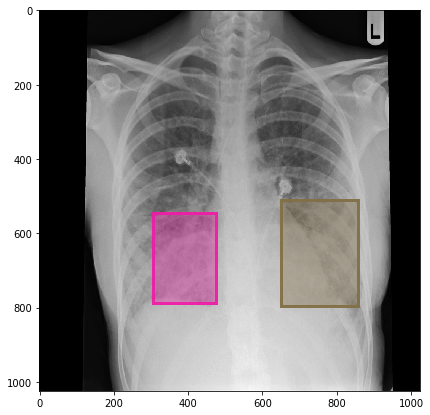

In [6]:
base = "../pneumonia"
train_info_path = base + "/stage_2_train_labels.csv"
data = pd.read_csv(train_info_path)

# get labels
idx = '00c0b293-48e7-4e16-ac76-9269ba535a62'
boxes = data[data['patientId'] == idx][['x', 'y', 'width', 'height']].values.tolist()

# get image
dcm_data = pydicom.read_file(base+'/stage_2_train_images/'+idx+'.dcm')
image = dcm_data.pixel_array

# draw image with labels
draw_boxes(image, boxes)

In [5]:
import keras
keras.__version__

'2.3.1'

In [7]:
# dataset was uncompressed
base = "../pneumonia"

# The directory where we will
# store our smaller dataset
base_dir = base + "/dataset"
# os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
# os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
# os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)

# Directory with our training positive pictures
train_positive_dir = os.path.join(train_dir, 'positive')
# os.mkdir(train_positive_dir)

# Directory with our training negative pictures
train_negative_dir = os.path.join(train_dir, 'negative')
# os.mkdir(train_negative_dir)

# Directory with our validation positive pictures
validation_positive_dir = os.path.join(validation_dir, 'positive')
# os.mkdir(validation_positive_dir)

# Directory with our validation negative pictures
validation_negative_dir = os.path.join(validation_dir, 'negative')
# os.mkdir(validation_negative_dir)

# Directory with our validation positive pictures
test_positive_dir = os.path.join(test_dir, 'positive')
# os.mkdir(test_positive_dir)

# Directory with our validation negative pictures
test_negative_dir = os.path.join(test_dir, 'negative')
# os.mkdir(test_negative_dir)

In [8]:
import png

def dicom2png(file, output_folder):
    try:
        ds = pydicom.dcmread(file + ".dcm")
        shape = ds.pixel_array.shape

        # Convert to float to avoid overflow or underflow losses.
        image_2d = ds.pixel_array.astype(float)

        # Rescaling grey scale between 0-255
        image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0

        # Convert to uint
        image_2d_scaled = np.uint8(image_2d_scaled)

        # Write the PNG file
        with open(output_folder +'.png' , 'wb') as png_file:
            w = png.Writer(shape[1], shape[0], greyscale=True)
            w.write(png_file, image_2d_scaled)
    except:
        print('Could not convert: ', file)

In [9]:
labels_dir = "/stage_2_train_labels.csv"
images_dir = "/stage_2_train_images"

labels = pd.read_csv(base+labels_dir)
labels = labels.drop_duplicates(["patientId"])

positive_ids = labels[labels["Target"] == 1]["patientId"].values.tolist()
train_positive_size = round(len(positive_ids) * 0.7)
validation_positive_size = round(len(positive_ids) * 0.15)

train_positive_ids = positive_ids[:train_positive_size]
validation_positive_ids = positive_ids[train_positive_size:(train_positive_size+validation_positive_size)]
test_positive_ids = positive_ids[(train_positive_size+validation_positive_size):]


negative_ids = labels[labels["Target"] == 0]["patientId"].values.tolist()[:6012]
train_negative_size = round(len(negative_ids) * 0.7)
validation_negative_size = round(len(negative_ids) * 0.15)

train_negative_ids = negative_ids[:train_negative_size]
validation_negative_ids = negative_ids[train_negative_size:(train_negative_size+validation_negative_size)]
test_negative_ids = negative_ids[(train_negative_size+validation_negative_size):]

print('total positive images:', len(positive_ids))
print('total negative images:', len(negative_ids))
print()
print('total training positive images:', len(train_positive_ids))
print('total training negative images:', len(train_negative_ids))
print()
print('total validation positive images:', len(validation_positive_ids))
print('total validation negative images:', len(validation_negative_ids))
print()
print('total test positive images:', len(test_positive_ids))
print('total test negative images:', len(test_negative_ids))

total positive images: 6012
total negative images: 6012

total training positive images: 4208
total training negative images: 4208

total validation positive images: 902
total validation negative images: 902

total test positive images: 902
total test negative images: 902


In [13]:
dataset = "/dataset"

print("Converting train positive images")
for value in train_positive_ids:
    src = os.path.join(base+images_dir,value)
    dst = os.path.join(base+dataset+"/train/positive",value)
    dicom2png(src, dst)
    
print("Converting train negative images")
for value in train_negative_ids:
    src = os.path.join(base+images_dir,value)
    dst = os.path.join(base+dataset+"/train/negative",value)
    dicom2png(src, dst)

print("Converting validation positive images")
for value in validation_positive_ids:
    src = os.path.join(base+images_dir,value)
    dst = os.path.join(base+dataset+"/validation/positive",value)
    dicom2png(src, dst)

print("Converting validation negative images")
for value in validation_negative_ids:
    src = os.path.join(base+images_dir,value)
    dst = os.path.join(base+dataset+"/validation/negative",value)
    dicom2png(src, dst)
    
print("Converting test positive images")
for value in test_positive_ids:
    src = os.path.join(base+images_dir,value)
    dst = os.path.join(base+dataset+"/test/positive",value)
    dicom2png(src, dst)
    
print("Converting test negative images")
for value in test_negative_ids:
    src = os.path.join(base+images_dir,value)
    dst = os.path.join(base+dataset+"/test/negative",value)
    dicom2png(src, dst)

print("Done")

Converting train positive images
Converting train negative images
Converting validation positive images
Converting validation negative images
Converting test positive images
Converting test negative images


In [10]:
print('total positive images:', len(positive_ids))
print('total negative images:', len(negative_ids))
print()
print('total training positive images:', len(os.listdir(train_positive_dir)))
print('total training negative images:', len(os.listdir(train_negative_dir)))
print()
print('total validation positive images:', len(os.listdir(validation_positive_dir)))
print('total validation negative images:', len(os.listdir(validation_negative_dir)))
print()
print('total test positive images:', len(os.listdir(test_positive_dir)))
print('total test negative images:', len(os.listdir(test_negative_dir)))

total positive images: 6012
total negative images: 6012

total training positive images: 4208
total training negative images: 4208

total validation positive images: 902
total validation negative images: 902

total test positive images: 902
total test negative images: 902


In [12]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [101]:
from keras.applications.densenet import DenseNet121
from keras import models
from keras import layers

input_shape = (500, 500, 3)
num_of_class = 1

img_in = layers.Input(input_shape)              #input of model 
model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= input_shape,
                pooling ='avg') 

x = model.output  
predictions = layers.Dense(num_of_class, activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
model = models.Model(inputs=img_in, outputs=predictions)

Exception ignored in: <bound method ScopedTFGraph.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFGraph object at 0x0000029B6DD8CC50>>
Traceback (most recent call last):
  File "C:\Development\Anaconda\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\c_api_util.py", line 51, in __del__
    if c_api is not None and c_api.TF_DeleteGraph is not None:
KeyboardInterrupt


In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 256)      

In [1]:
from keras import optimizers

model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=["accuracy"],
)

Using TensorFlow backend.


NameError: name 'model' is not defined

In [14]:
from keras import optimizers

optimizer = optimizers.Adam(lr=0.001)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=[keras.metrics.binary_accuracy],
)

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

epochs = 30
batch_size = 32
num_of_train_samples = len(os.listdir(train_positive_dir)) + len(os.listdir(train_negative_dir))
num_of_test_samples = len(os.listdir(validation_positive_dir)) + len(os.listdir(validation_negative_dir))

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(224, 224),
    batch_size=batch_size,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode="binary",
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
)

Found 8416 images belonging to 2 classes.
Found 1804 images belonging to 2 classes.


In [16]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32,)


In [17]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=num_of_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=num_of_test_samples // batch_size,
#     use_multiprocessing=True,
#     workers = 4
)

Epoch 1/30
263/263 [==============================] - 119s 452ms/step - loss: 0.5802 - binary_accuracy: 0.7043 - val_loss: 0.6098 - val_binary_accuracy: 0.7054
Epoch 2/30
263/263 [==============================] - 98s 373ms/step - loss: 0.5409 - binary_accuracy: 0.7405 - val_loss: 0.6151 - val_binary_accuracy: 0.6699
Epoch 3/30
263/263 [==============================] - 98s 371ms/step - loss: 0.5277 - binary_accuracy: 0.7430 - val_loss: 0.5255 - val_binary_accuracy: 0.7043
Epoch 4/30
263/263 [==============================] - 97s 370ms/step - loss: 0.5218 - binary_accuracy: 0.7488 - val_loss: 0.6594 - val_binary_accuracy: 0.7156
Epoch 5/30
263/263 [==============================] - 97s 369ms/step - loss: 0.5165 - binary_accuracy: 0.7504 - val_loss: 0.6215 - val_binary_accuracy: 0.7195
Epoch 6/30
263/263 [==============================] - 97s 369ms/step - loss: 0.5060 - binary_accuracy: 0.7596 - val_loss: 0.5789 - val_binary_accuracy: 0.7156
Epoch 7/30
263/263 [=========================

In [18]:
model.save('pneumonia.h5')

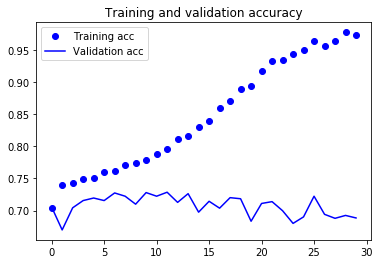

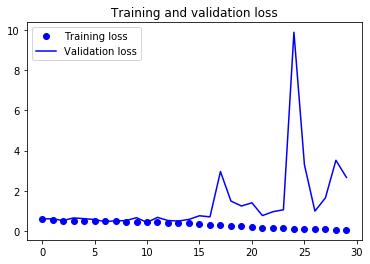

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = [1 * (x[0]>=0.5) for x in Y_pred]
# print("y_pred", y_pred)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred))
print("Classification Report")
target_names = ["negative", "positive"]
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[442 460]
 [421 481]]
Classification Report
              precision    recall  f1-score   support

    negative       0.51      0.49      0.50       902
    positive       0.51      0.53      0.52       902

    accuracy                           0.51      1804
   macro avg       0.51      0.51      0.51      1804
weighted avg       0.51      0.51      0.51      1804

